In [27]:
import numpy
import pandas
import matplotlib.pyplot as plt
import csv
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn
from math import sqrt

https://www.pluralsight.com/guides/predictive-analytics-with-pytorch

In [39]:
schools = pandas.read_csv("/home/azureuser/cloudfiles/code/Users/ariley/Data/Schools/School_Counts/NE_10km_school_count_wData.csv")

schools = schools.iloc[:, 2:]
schools = schools.drop(columns = ['ID'])

schools = schools.dropna()

df = schools

df.head()

target_column = ['NUMPOINTS'] 
predictors = list(set(list(df.columns))-set(target_column))

print(target_column)
print(predictors)

X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 30)
print(X_train.shape); print(X_test.shape)


['NUMPOINTS']
['x', 'smod..13', 'built_v', 'land', 'smod..10', 'smod..11', 'smod..12', 'smod..30', 'y', 'smod..21', 'pop', 'smod..22', 'smod..23', 'built_s']
(25943, 14)
(11119, 14)


In [40]:
class ANN(nn.Module):
    def __init__(self, input_dim = 8, output_dim = 1):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32,1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output_layer(x)
        
        #return nn.Sigmoid()(x)
        return nn.ReLU()(x)

In [41]:
model = ANN(input_dim = 14, output_dim = 1)



print(model)

ANN(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)


In [42]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)#.view(-1,1)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)#.view(-1,1)

train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 64, shuffle = True)

In [43]:
import torch.optim as optim
#loss_fn = nn.BCELoss()
#loss_fn = nn.CrossEntropyLoss()

def loss_fn(pred, obs):
    """Custom loss function for Poisson model."""
    loss = torch.mean(pred-obs*torch.log(pred))
    return loss

loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay= 1e-6, momentum = 0.8)

In [45]:
# lines 1 to 6
epochs = 10 #2000
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# lines 7 onwards
model.train() # prepare model for training

for epoch in range(epochs):
    trainloss = 0.0
    valloss = 0.0
    
    correct = 0
    total = 0
    for data,target in train_loader:
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)
        optimizer.zero_grad()
        output = model(data)
        predicted = (torch.round(output.data[0]))
        total += len(target)
        correct += (predicted == target).sum()

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()*data.size(0)

    trainloss = trainloss/len(train_loader.dataset)
    accuracy = 100 * correct / float(total)
    train_acc_list.append(accuracy)
    train_loss_list.append(trainloss)
    print('Epoch: {} \tTraining Loss: {:.4f}\t Acc: {:.2f}%'.format(
        epoch+1, 
        trainloss,
        accuracy
        ))
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 2 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 3 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 4 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 5 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 6 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 7 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 8 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 9 	Training Loss: 257.8686	 Acc: 73.90%
Epoch: 10 	Training Loss: 257.8686	 Acc: 73.90%


tensor(73.5678)
[0.]


(array([174.,   0.,   0.]),
 array([ -1,   1,  10, 102]),
 <a list of 3 Patch objects>)

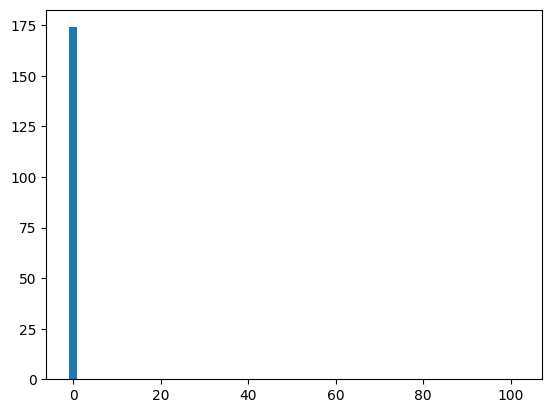

In [46]:
correct = 0
total = 0
valloss = 0
model.eval() 
predicted = []


with torch.no_grad():
    for data, target in test_loader:
        data = Variable(data).float()
        target = Variable(target).type(torch.FloatTensor)

        output = model(data)
        loss = loss_fn(output, target)
        valloss += loss.item()*data.size(0)
        
        pred = (torch.round(output.data[0]))
        predicted.append(torch.round(output.data[0]))
        total += len(target)
        #correct += (predicted == target).sum()
        correct += (pred == target).sum()
    
    valloss = valloss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    print(accuracy) 
    
#print(predicted)

out = torch.cat(predicted, dim = 0)
#print(out)

out_array = numpy.array(out)
#print(out_array)

print(numpy.unique(out_array))

plt.hist(out_array, bins = [-1,1,10,102])